# Predict Delayed Flights

In [94]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import os
df = pd.read_csv('../assets/data_prep_majority.txt', sep="\t", encoding="utf-8")

In [95]:
_df = df.copy()
_df.sample(5)

,Flight,Date,Equipment_Type,Equipment_Reg,Origin_City,Origin_Code,Destination_City,Destination_Code,Flight Time,ETD,ETA,ATD,ATA,Carrier_Name,Carrier_Class,Timedelta,ETD_Group,Delayed
119463,FR3100,2019-09-19,B738,EI-EKE,Dublin,DUB,Amsterdam,AMS,1:14,05:50,9:30,06:46,10:00,Ryanair,1,30,Red Eye,1
130334,SK536,2018-12-10,A20N,SE-ROB,Dublin,DUB,Stockholm,ARN,2:17,11:45,16:25,12:03,16:20,SAS,0,-5,Afternoon,0
167757,IB3192,2019-11-13,A319,EC-JVE,Madrid,MAD,Munich,MUC,1:59,16:40,19:20,16:53,18:52,Iberia,0,-28,Afternoon,0
129277,SK535,2019-08-18,A20N,SE-ROE,Stockholm,ARN,Dublin,DUB,2:21,7:40,10:25,8:06,10:27,SAS,0,2,Morning,0
61026,SK844,2019-01-08,B736,LN-RRO,Oslo,OSL,Stockholm,ARN,0:44,6:55,8:00,7:15,07:59,SAS,0,-1,Red Eye,0


In [96]:
_df['Weekday'] = [str(datetime.strptime(date, '%Y-%m-%d').strftime('%A')) for date in _df['Date']]

In [97]:
selected_vars = _df[['ETD_Group', 'Weekday', 'Origin_City', 'Destination_City', 'Equipment_Type', 'Carrier_Name', 'Carrier_Class', 'Delayed']]

In [98]:
selected_vars.head()

,ETD_Group,Weekday,Origin_City,Destination_City,Equipment_Type,Carrier_Name,Carrier_Class,Delayed
0,Evening,Sunday,Frankfurt,London,A20N,Lufthansa,0,0
1,Evening,Saturday,Frankfurt,London,A20N,Lufthansa,0,0
2,Evening,Friday,Frankfurt,London,A320,Lufthansa,0,0
3,Evening,Thursday,Frankfurt,London,A20N,Lufthansa,0,0
4,Evening,Wednesday,Frankfurt,London,A20N,Lufthansa,0,0


In [99]:
for _ in list(selected_vars.columns):
    selected_vars[_] = LabelEncoder().fit_transform(_df[_])

In [100]:
df_split = selected_vars.loc[np.random.choice(selected_vars[selected_vars['Delayed']==1].index, 20000, replace = True)]
df_split2 = selected_vars.loc[np.random.choice(selected_vars[selected_vars['Delayed']==0].index, 30000, replace = True)]
df_split = df_split.append(df_split2, ignore_index=True)

In [101]:
x = selected_vars.drop(['Delayed'], axis=1)
y = selected_vars['Delayed']

## Modeling

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import defaultdict

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO

from IPython.display import Image
#import pydotplus
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder

In [103]:
#Split data into 3: 60% train, 20% validation, 20% test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=888)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=999)

In [104]:

gbm = xgb.XGBClassifier( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:linear",
                       learning_rate=.3, 
                       subsample=1,scale_pos_weight=5,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(x_train,y_train),(x_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    x_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

[19:10:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-auc:0.55653	validation_1-auc:0.55705
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.60522	validation_1-auc:0.60658
[2]	validation_0-auc:0.61137	validation_1-auc:0.61216
[3]	validation_0-auc:0.61461	validation_1-auc:0.61541
[4]	validation_0-auc:0.62009	validation_1-auc:0.62015
[5]	validation_0-auc:0.62552	validation_1-auc:0.62514
[6]	validation_0-auc:0.62961	validation_1-auc:0.62973
[7]	validation_0-auc:0.63094	validation_1-auc:0.63152
[8]	validation_0-auc:0.63301	validation_1-auc:0.63283
[9]	validation_0-auc:0.63704	validation_1-auc:0.63658
[10]	validation_0-auc:0.63964	validation_1-auc:0.63878
[11]	validation_0-auc:0.64049	validation_1-auc:0.63976
[12]	validation_

In [105]:

gbm_pred = gbm.predict(x_test, ntree_limit=gbm.best_ntree_limit)
gbm_accuracy = accuracy_score(y_test, gbm_pred)
gbm_f1 = f1_score(y_test, gbm_pred)
print('XGBoost Accuracy:', gbm_accuracy)
print('XGBoost F1:', gbm_f1)

XGBoost Accuracy: 0.5543037404236142
XGBoost F1: 0.37690974956686085


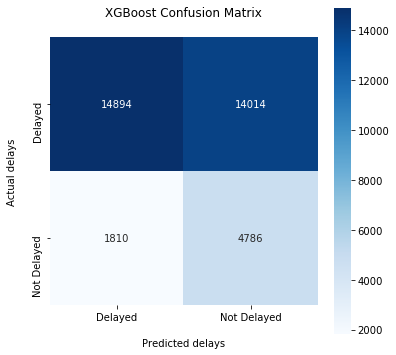

In [106]:
xgb_confusion = confusion_matrix(y_test, gbm_pred)
plt.figure(figsize=(6,6))
labels = ['Delayed', 'Not Delayed']
sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True, xticklabels=labels, yticklabels=labels, fmt='g')
plt.xlabel('\nPredicted delays')
plt.ylabel('Actual delays\n')
plt.title('XGBoost Confusion Matrix\n');

In [107]:
gbm_all = xgb.XGBClassifier( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:linear",
                       learning_rate=.3, 
                       subsample=1, scale_pos_weight=5,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(x_train,y_train),(x_val,y_val)] #tracking train/validation error as we go
fit_model = gbm_all.fit( 
                    x_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

[19:11:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-auc:0.55653	validation_1-auc:0.55705
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.60522	validation_1-auc:0.60658
[2]	validation_0-auc:0.61137	validation_1-auc:0.61216
[3]	validation_0-auc:0.61461	validation_1-auc:0.61541
[4]	validation_0-auc:0.62009	validation_1-auc:0.62015
[5]	validation_0-auc:0.62552	validation_1-auc:0.62514
[6]	validation_0-auc:0.62961	validation_1-auc:0.62973
[7]	validation_0-auc:0.63094	validation_1-auc:0.63152
[8]	validation_0-auc:0.63301	validation_1-auc:0.63283
[9]	validation_0-auc:0.63704	validation_1-auc:0.63658
[10]	validation_0-auc:0.63964	validation_1-auc:0.63878
[11]	validation_0-auc:0.64049	validation_1-auc:0.63976
[12]	validation_

In [108]:
gbm_all_pred = gbm_all.predict(x_test, ntree_limit=gbm_all.best_ntree_limit)
gbm_all_accuracy = accuracy_score(y_test, gbm_all_pred)
gbm_all_f1 = f1_score(y_test, gbm_all_pred)
print('XGBoost Test Accuracy:', gbm_all_accuracy)
print('XGBoost Test F1:', gbm_all_f1)

XGBoost Test Accuracy: 0.5543037404236142
XGBoost Test F1: 0.37690974956686085


In [109]:
gbm_val_pred = gbm_all.predict(x_val, ntree_limit=gbm_all.best_ntree_limit)
gbm_val_accuracy = accuracy_score(y_val, gbm_val_pred)
gbm_val_f1 = f1_score(y_val, gbm_val_pred)
print('XGBoost Validation Accuracy:', gbm_val_accuracy)
print('XGBoost Validation F1:', gbm_val_f1)

XGBoost Validation Accuracy: 0.5592485142100667
XGBoost Validation F1: 0.3836943678613627


Text(0.5, 1, 'XGBoost Confusion Matrix\n')

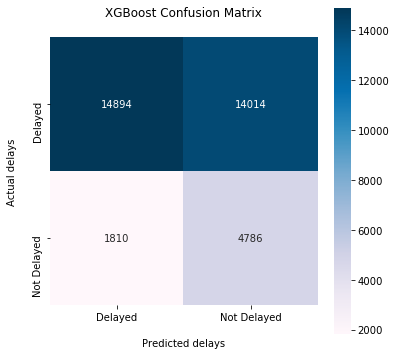

In [110]:
xgb_confusion = confusion_matrix(y_test, gbm_all_pred)
plt.figure(figsize=(6,6))
labels = ['Delayed', 'Not Delayed']
sns.heatmap(xgb_confusion, cmap='PuBu', annot=True, square=True
            , xticklabels=labels, yticklabels=labels, fmt='g')
plt.xlabel('\nPredicted delays')
plt.ylabel('Actual delays\n')
plt.title('XGBoost Confusion Matrix\n')

In [111]:
_df.Delayed.value_counts()

0    144311
1     33205
Name: Delayed, dtype: int64

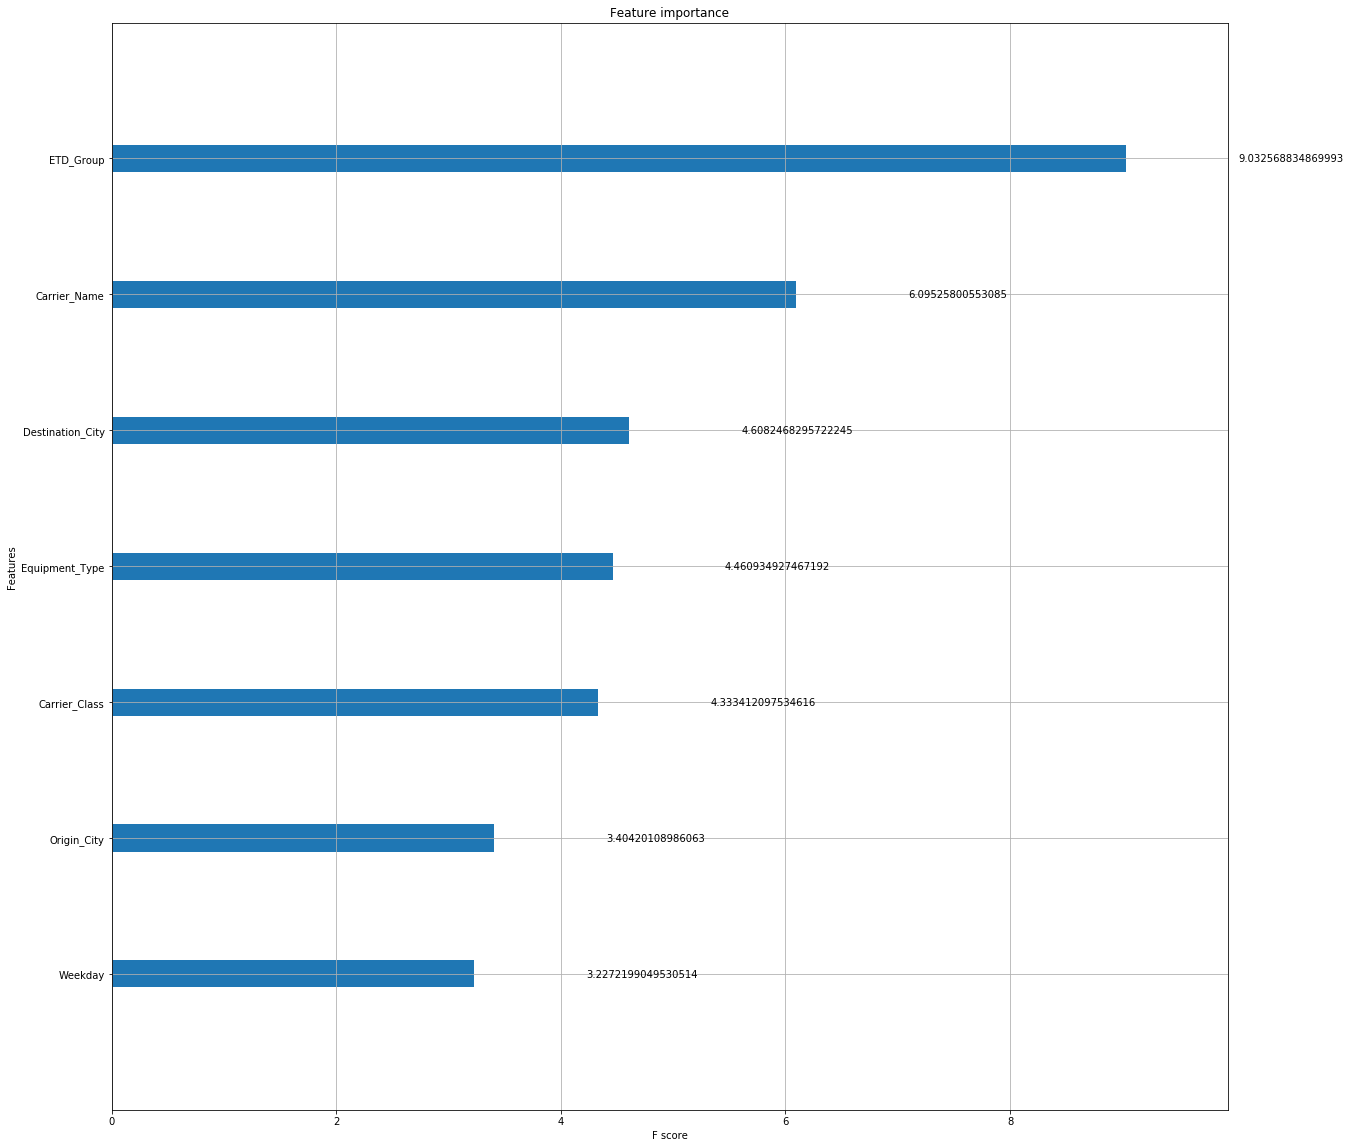

In [112]:

fig, ax = plt.subplots(figsize=(20,20))
# xgb.plot_importance(gbm)
xgb.plot_importance(gbm_all, importance_type='gain', ax=ax)

## Equipment Type Check